In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BranchNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, output_dim),
        )
    
    def forward(self, x):
        return self.net(x)

class TrunkNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, output_dim),
        )
    
    def forward(self, y):
        return self.net(y)

class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
        self.iter = 0

    def forward(self, x, y):
        # x: [batch, branch_input_dim]
        # y: [batch, trunk_input_dim]
        branch_out = self.branch_net(x)  # [batch, latent_dim]
        trunk_out = self.trunk_net(y)    # [batch, latent_dim]
        out = torch.sum(branch_out * trunk_out, dim=1, keepdim=True)  # [batch, 1]
        return out

    def loss(self, x, y, target):
        pred = self.forward(x, y)
        return F.mse_loss(pred, target)
    
    def inference(self, velocity, time):
        self.eval()  # Set the model to evaluation mode

        # Ensure velocity is a tensor of shape [1, 250]
        if velocity.ndimension() == 1:
            velocity = velocity.unsqueeze(0)  # [1, 250]
        
        # Ensure time is a tensor of shape [T, 1]
        if time.ndimension() == 1:
            time = time.unsqueeze(1)  # [T, 1]
        
        # Perform the forward pass for all time steps
        with torch.no_grad():
            predictions = self.forward(velocity, time)  # [1, T, 1]
        
        return predictions.squeeze()  # [T, 1] for the friction coefficients
    
    def closure(self, optimizer, x, y, target):
        def _closure():
            optimizer.zero_grad()
            loss = self.loss(x, y, target)
            loss.backward()

            if self.iter % 500 == 0:
                print(f"Loss: {loss.item()}")
            self.iter += 1
            return loss
        return _closure

        

In [13]:
velocity = pd.read_csv('synthetic_data_generation/features.csv', header = None)
fric_coef = pd.read_csv('synthetic_data_generation/targets_AgingLaw.csv', header = None)

max_fric = fric_coef.to_numpy().max()
min_fric = fric_coef.to_numpy().min()

max_vel = velocity.to_numpy().max()

vel_size = len(velocity.columns)

In [14]:
fric_coef = (np.array(fric_coef) - min_fric) / (max_fric - min_fric)

velocity = np.log(np.log(1/np.array(velocity)))
min_vel = velocity.min()
max_vel = velocity.max()
velocity = (velocity - min_vel) / (max_vel - min_vel)

In [15]:
Vmax = 1.0e-1
Dc = 1.0e-1
nTransient = 300
delta_t = (Dc / Vmax) / nTransient

total_time = delta_t * 250
time = np.arange(0, total_time, delta_t)

In [16]:
from torch.utils.data import Dataset

class DeepONetDataset(Dataset):
    def __init__(self, velocity, time, fric_coef):
        # Convert to tensors
        self.velocity = torch.tensor(velocity, dtype=torch.float32)  # [N_exp, 250]
        self.time = torch.tensor(time, dtype=torch.float32).unsqueeze(1)    # [T, 1]
        self.fric_coef = torch.tensor(fric_coef, dtype=torch.float32)  # [N_exp, 250]

        self.N, self.T = self.fric_coef.shape

    def __len__(self):
        return self.N * self.T

    def __getitem__(self, idx):
        exp_idx = idx // self.T
        time_idx = idx % self.T

        velocity_sample = self.velocity[exp_idx]           # [250]
        time_sample = self.time[time_idx]                  # [1]
        fric_value = self.fric_coef[exp_idx, time_idx]     # scalar

        return velocity_sample, time_sample, fric_value.unsqueeze(0)  # [250], [1], [1]


In [17]:
from torch.utils.data import DataLoader

dataset = DeepONetDataset(velocity, time, fric_coef)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [18]:
BranchNet = BranchNet(input_dim=vel_size, output_dim=32)
TrunkNet = TrunkNet(input_dim=1, output_dim=32)
model = DeepONet(BranchNet, TrunkNet)

In [19]:
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# params = list(model.parameters())
# optimizer_BFGS = torch.optim.LBFGS(params, lr=1.0, 
#                                 max_iter = 1, 
#                                 max_eval = 100, 
#                                 tolerance_grad = 1e-20, 
#                                 tolerance_change = 1e-6 * 1e-6, 
#                                 history_size = 100, 
#                                 line_search_fn = "strong_wolfe")

for epoch in range(100):
    model.train()
    running_loss = 0.0

    for batch in dataloader:
        vel_batch, time_batch, target_batch = batch
        #closure_fn = model.closure(optimizer_BFGS, vel_batch, time_batch, target_batch)
        # optimizer_BFGS.step(closure_fn)
        # loss = optimizer_BFGS.step(model.closure(optimizer_BFGS, vel_batch, time_batch, target_batch))
        optimizer.zero_grad()
        loss = model.loss(vel_batch, time_batch, target_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * vel_batch.size(0)

    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch}, Loss: {epoch_loss:.3e}")

Epoch 0, Loss: 6.152e-03
Epoch 1, Loss: 4.041e-03
Epoch 2, Loss: 3.089e-03
Epoch 3, Loss: 2.685e-03
Epoch 4, Loss: 2.497e-03
Epoch 5, Loss: 2.217e-03
Epoch 6, Loss: 1.965e-03
Epoch 7, Loss: 1.888e-03
Epoch 8, Loss: 1.805e-03
Epoch 9, Loss: 1.692e-03
Epoch 10, Loss: 1.618e-03
Epoch 11, Loss: 1.567e-03
Epoch 12, Loss: 1.495e-03
Epoch 13, Loss: 1.464e-03
Epoch 14, Loss: 1.429e-03
Epoch 15, Loss: 1.388e-03
Epoch 16, Loss: 1.327e-03
Epoch 17, Loss: 1.283e-03
Epoch 18, Loss: 1.253e-03
Epoch 19, Loss: 1.186e-03
Epoch 20, Loss: 1.153e-03
Epoch 21, Loss: 1.133e-03
Epoch 22, Loss: 1.119e-03
Epoch 23, Loss: 1.120e-03
Epoch 24, Loss: 1.103e-03
Epoch 25, Loss: 1.090e-03
Epoch 26, Loss: 1.075e-03
Epoch 27, Loss: 1.070e-03
Epoch 28, Loss: 1.067e-03
Epoch 29, Loss: 1.061e-03
Epoch 30, Loss: 1.049e-03
Epoch 31, Loss: 1.033e-03
Epoch 32, Loss: 1.020e-03
Epoch 33, Loss: 1.016e-03
Epoch 34, Loss: 1.010e-03
Epoch 35, Loss: 1.001e-03
Epoch 36, Loss: 9.824e-04
Epoch 37, Loss: 9.818e-04
Epoch 38, Loss: 9.723e

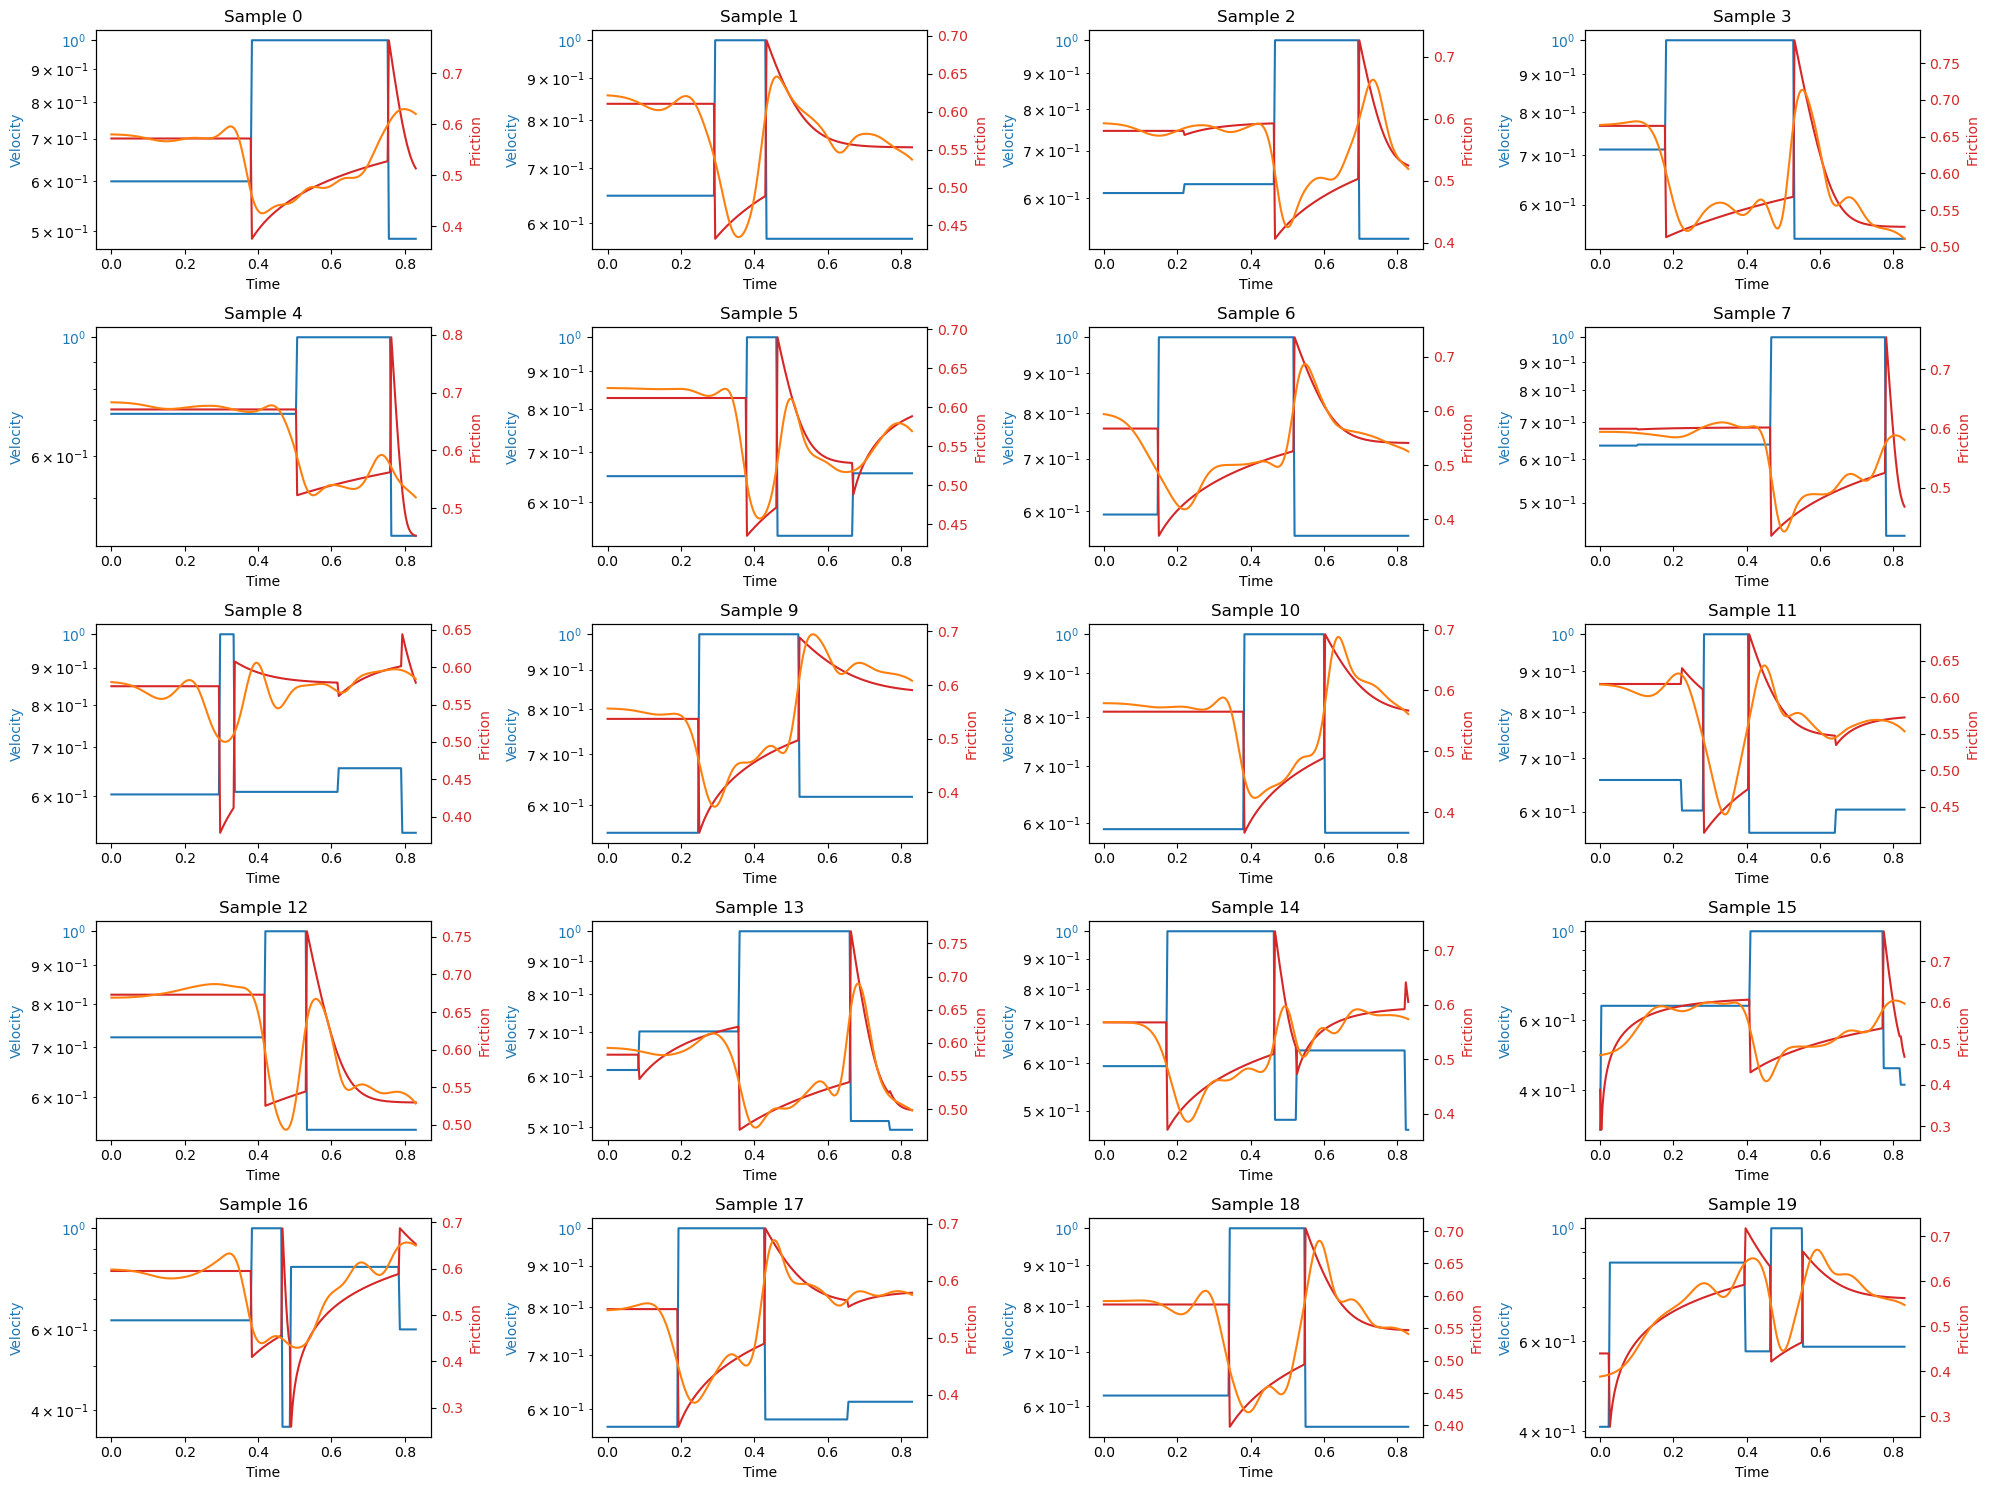

In [20]:
# import matplotlib.pyplot as plt


# for row in range(0, 20):

#     # Create a figure and axis
#     fig, ax1 = plt.subplots()

#     # Plot velocity on the first y-axis
#     ax1.plot(time, velocity[row, :], label='Velocity', color='tab:blue')
#     ax1.set_xlabel('Time')
#     ax1.set_ylabel('Velocity', color='tab:blue')
#     ax1.tick_params(axis='y', labelcolor='tab:blue')
#     ax1.set_yscale('log')  # Log scale for velocity

#     # Create a second y-axis that shares the same x-axis
#     ax2 = ax1.twinx()

#     # Plot friction coefficient on the second y-axis
#     ax2.plot(time, fric_coef[row, :], label='Friction Coefficient', color='tab:red')
#     ax2.set_ylabel('Friction Coefficient', color='tab:red')
#     ax2.tick_params(axis='y', labelcolor='tab:red')

#     output = model.inference(torch.Tensor(velocity[row, :]), torch.Tensor(time))
#     ax2.plot(time, output, label='Predicted Friction Coefficient', color='tab:orange')



#     # Display the plot
#     fig.tight_layout()  # Adjust the layout to prevent overlapping labels
#     plt.legend()
#     plt.show()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 4, figsize=(20, 15))  # 5 rows, 4 columns

for idx in range(20):
    row = idx // 4
    col = idx % 4

    ax1 = axs[row, col]
    
    # Plot velocity on primary y-axis
    ax1.plot(time, velocity[idx, :], label='Velocity', color='tab:blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Velocity', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_yscale('log')

    # Twin axis for friction
    ax2 = ax1.twinx()
    ax2.plot(time, fric_coef[idx, :], label='Friction Coefficient', color='tab:red')
    output = model.inference(torch.Tensor(velocity[idx, :]), torch.Tensor(time))
    ax2.plot(time, output, label='Predicted Friction Coefficient', color='tab:orange')
    ax2.set_ylabel('Friction', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    ax1.set_title(f"Sample {idx}")

# Adjust layout and show
plt.tight_layout()
plt.show()
